In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier # Our chosen ML model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # For saving the trained model later

# --- Re-load the dataset ---
file_path = '../data/raw/diabetes_prediction_dataset.csv'
diabetes_df = pd.read_csv(file_path)

# --- Re-identify Features and Target ---
target = 'diabetes'
X = diabetes_df.drop(columns=[target])
y = diabetes_df[target]

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

# --- Re-define Preprocessing Transformers ---
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# --- Re-define ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Libraries imported, dataset loaded, and preprocessing components re-defined.")

Libraries imported, dataset loaded, and preprocessing components re-defined.


In [2]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print(f"Data split into training and testing sets:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train distribution:\n{y_train.value_counts(normalize=True)}")
print(f"y_test distribution:\n{y_test.value_counts(normalize=True)}")

Data split into training and testing sets:
X_train shape: (80000, 8)
X_test shape: (20000, 8)
y_train distribution:
diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64
y_test distribution:
diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64


In [3]:
# Create the full pipeline: Preprocessing + Classifier
# RandomForestClassifier is a powerful, versatile model.
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), # Apply all preprocessing steps
    ('classifier', RandomForestClassifier(random_state=42)) # Then apply the classifier
])

print("Training the model pipeline...")
# Train the pipeline on the training data
model_pipeline.fit(X_train, y_train)

print("Model training completed.")

Training the model pipeline...
Model training completed.


In [4]:
# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# Get prediction probabilities (useful for ROC-AUC and for confidence scores in the app)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1] # Probability of the positive class (diabetes=1)

print("Predictions made on the test set.")

Predictions made on the test set.



Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.95      0.69      0.80      1700

    accuracy                           0.97     20000
   macro avg       0.96      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000


Confusion Matrix:
[[18232    68]
 [  529  1171]]


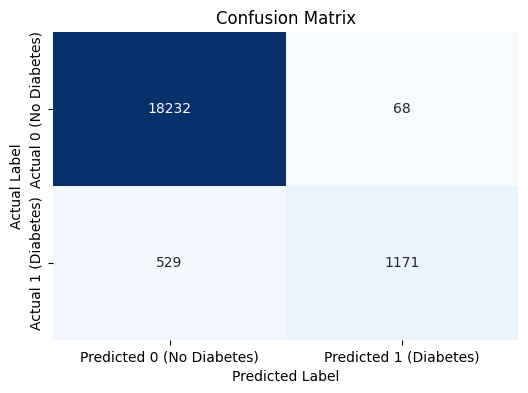


--- Model Performance Metrics ---
Accuracy: 0.9701
Precision (Class 1): 0.9451
Recall (Class 1): 0.6888
F1-Score (Class 1): 0.7969
ROC AUC Score: 0.9604

Interpretation for Imbalanced Dataset:
 - Accuracy alone can be misleading when classes are imbalanced (like our diabetes data).
 - Precision (for Class 1 'Diabetes'): Out of all predictions of 'Diabetes', how many were actually 'Diabetes'?
 - Recall (for Class 1 'Diabetes'): Out of all actual 'Diabetes' cases, how many did the model correctly identify?
 - F1-Score: A balanced measure of Precision and Recall. Good for imbalanced datasets.
 - ROC AUC Score: Measures the model's ability to distinguish between classes. A higher score (closer to 1) is better.


In [5]:
# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0 (No Diabetes)', 'Predicted 1 (Diabetes)'],
            yticklabels=['Actual 0 (No Diabetes)', 'Actual 1 (Diabetes)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# --- Key Metrics ---
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n--- Model Performance Metrics ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Class 1): {precision:.4f}")
print(f"Recall (Class 1): {recall:.4f}")
print(f"F1-Score (Class 1): {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# --- Interpretation for Imbalanced Data ---
print("\nInterpretation for Imbalanced Dataset:")
print(" - Accuracy alone can be misleading when classes are imbalanced (like our diabetes data).")
print(" - Precision (for Class 1 'Diabetes'): Out of all predictions of 'Diabetes', how many were actually 'Diabetes'?")
print(" - Recall (for Class 1 'Diabetes'): Out of all actual 'Diabetes' cases, how many did the model correctly identify?")
print(" - F1-Score: A balanced measure of Precision and Recall. Good for imbalanced datasets.")
print(" - ROC AUC Score: Measures the model's ability to distinguish between classes. A higher score (closer to 1) is better.")


Top 10 Feature Importances:
HbA1c_level                0.406036
blood_glucose_level        0.314790
bmi                        0.124336
age                        0.104748
hypertension               0.015917
heart_disease              0.011017
smoking_history_No Info    0.004740
smoking_history_former     0.003643
smoking_history_never      0.003336
smoking_history_current    0.002461
dtype: float64


C:\Users\irann\AppData\Local\Temp\ipykernel_16544\2809963551.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.head(10).values, y=feature_importances.head(10).index, palette='viridis')


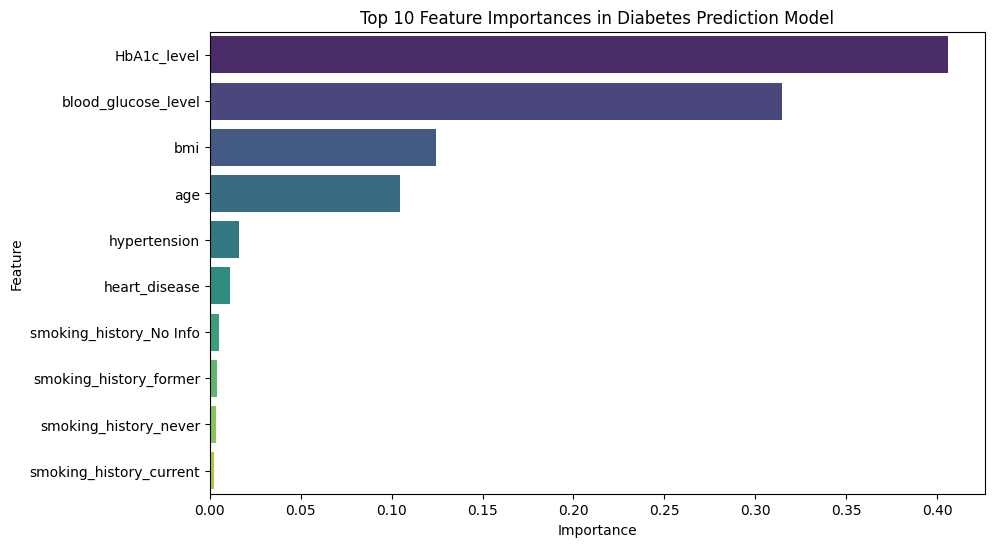

In [6]:
# --- Feature Importance (for RandomForestClassifier) ---
# Only applicable if the classifier provides feature_importances_ (like RandomForest)
if hasattr(model_pipeline.named_steps['classifier'], 'feature_importances_'):
    # Get feature names after one-hot encoding
    # This requires accessing the OneHotEncoder's feature names
    ohe = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    categorical_feature_names = ohe.get_feature_names_out(categorical_features)

    # Combine numerical and one-hot encoded categorical feature names
    all_feature_names = numerical_features + list(categorical_feature_names)

    importances = model_pipeline.named_steps['classifier'].feature_importances_
    feature_importances = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)

    print("\nTop 10 Feature Importances:")
    print(feature_importances.head(10))

    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances.head(10).values, y=feature_importances.head(10).index, palette='viridis')
    plt.title('Top 10 Feature Importances in Diabetes Prediction Model')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
else:
    print("\nClassifier does not have 'feature_importances_'.")

In [7]:
# Save the trained model pipeline
# The 'wb' mode means 'write binary'
joblib.dump(model_pipeline, '../models/diabetes_risk_model_pipeline.pkl')

# Optionally, save the lists of numerical and categorical features.
# This can be useful for the Streamlit app to know what inputs to expect and how to order them.
joblib.dump(numerical_features, '../models/numerical_features.pkl')
joblib.dump(categorical_features, '../models/categorical_features.pkl')

print("Trained diabetes model pipeline and feature lists saved to 'models/' folder.")

Trained diabetes model pipeline and feature lists saved to 'models/' folder.
